Split training data into correct folders
--------------------------------------

In [14]:
sort_data = None

%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from utils import *
from vgg16 import Vgg16

path = 'data/invasive-species-monitoring/'
labels = np.genfromtxt(path + 'train_labels.csv', dtype=None, delimiter=',', names=True)

In [84]:
def cpRandomJpgs(frm, to, num):
    %mkdir -p {path + to}
    g = glob(path + frm + '/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(num):
        %cp {shuf[i]} {path + to + '/.'}

def mvRandomJpgs(frm, to, num):
    %mkdir -p {path + to}
    g = glob(path + frm + '/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(num):
        %mv {shuf[i]} {path + to + '/.'}
    
def formatData():
    %mkdir {path + 'train/non-invasive'}
    %mkdir {path + 'train/invasive'}
    
    for record in labels:
        folder = 'invasive/' if np.int(record[1]) == 1 else 'non-invasive/'
        %cp {path}train/{record[0]}.jpg {path}train/{folder}{record[0]}.jpg
    
    mvRandomJpgs('train/invasive', 'valid/invasive', 200)
    mvRandomJpgs('train/non-invasive', 'valid/non-invasive', 200)
    cpRandomJpgs('train/invasive', 'sample/train/invasive', 10)
    cpRandomJpgs('train/non-invasive', 'sample/train/non-invasive', 10)
    cpRandomJpgs('valid/invasive', 'sample/valid/invasive', 10)
    cpRandomJpgs('valid/non-invasive', 'sample/valid/non-invasive', 10)
    cpRandomJpgs('test', 'sample/test/unknown', 10)

    # Need to also move test data to a label "unknown"
    %mkdir -p {path + '/test/unknown'}
    %cp {path + 'test/*.jpg'} {path + 'test/unknown/.'}

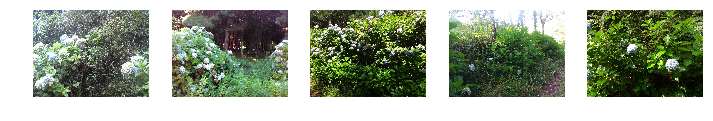

In [82]:
if sort_data:
    formatData()
    
def show5Random(folder):
    g = glob(path + folder + '/*.jpg')
    shuf = np.random.permutation(g)
    plots([image.load_img(shuf[i]) for i in range(5)])
    
# Show a few invasive species
show5Random('valid/invasive')


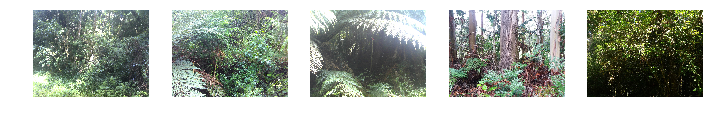

In [17]:
# Show a few non-invasive species
show5Random('valid/non-invasive')

In [18]:
vgg = Vgg16()

#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64

In [20]:
final_path = path + 'sample/'
#final_path = path

In [99]:
model_path = final_path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [86]:
#Finetune the model
batches = vgg.get_batches(final_path + 'train', batch_size=batch_size)
val_batches = vgg.get_batches(final_path + 'valid', batch_size=batch_size*2)

Found 20 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [100]:
vgg.finetune(batches)

In [101]:
def fit(id, num_epochs, lr):
    vgg.model.optimizer.lr = lr
    no_of_epochs=num_epochs
    for epoch in range(no_of_epochs):
        print('Running epoch: %d' % epoch)
        vgg.fit(batches, val_batches, nb_epoch=1)
        latest_weights_filename = '/finetuned_' + str(id) + '_%d.h5' % epoch
        vgg.model.save_weights(model_path + latest_weights_filename)
    print("Completed %s fit operations" % no_of_epochs)
    
fit(1, 2, 0.0001)
fit(2, 2, 0.1)
fit(3, 8, 0.01)
fit(4, 10, 0.001)
fit(5, 10, 0.0001)

Running epoch: 0
Epoch 1/1
20/20 [==============================] - 27s - loss: 1.3208 - acc: 0.5500 - val_loss: 0.9866 - val_acc: 0.3500
Running epoch: 1
Epoch 1/1
20/20 [==============================] - 27s - loss: 0.8558 - acc: 0.5500 - val_loss: 0.9534 - val_acc: 0.4500
Completed 2 fit operations
Running epoch: 0
Epoch 1/1
20/20 [==============================] - 27s - loss: 1.2692 - acc: 0.5500 - val_loss: 0.9219 - val_acc: 0.4500
Running epoch: 1
Epoch 1/1
20/20 [==============================] - 27s - loss: 1.0393 - acc: 0.4500 - val_loss: 0.8927 - val_acc: 0.4500
Completed 2 fit operations
Running epoch: 0
Epoch 1/1
20/20 [==============================] - 26s - loss: 1.0596 - acc: 0.4500 - val_loss: 0.8663 - val_acc: 0.5000
Running epoch: 1
Epoch 1/1
20/20 [==============================] - 26s - loss: 1.4915 - acc: 0.5000 - val_loss: 0.8425 - val_acc: 0.5500
Running epoch: 2
Epoch 1/1
20/20 [==============================] - 28s - loss: 1.0813 - acc: 0.5000 - val_loss: 0.819

Create prediction csv
---------------------

In [142]:
# Let's remove dropout (to stop underfitting)
model = vgg_ft(2)

In [143]:
model.load_weights(model_path + 'finetuned_5_9.h5')

In [144]:
layers = model.layers

In [145]:
last_conv_id = [index for index, item in enumerate(layers) if type(item) == Convolution2D][-1]
last_conv_id

30

In [146]:
conv_layers = layers[:last_conv_id+1]

In [147]:
fc_layers = layers[last_conv_id+1:]

In [148]:
conv_model = Sequential(conv_layers)
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_6 (Lambda)                (None, 3, 224, 224)   0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
zeropadding2d_66 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_6[0][0]                   
                                                                   lambda_6[0][0]                   
____________________________________________________________________________________________________
convolution2d_66 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_66[0][0]           
                                                                   zeropadding2d_66[1][0]           
___________________________________________________________________________________________

Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
____________________________________________________________________________________________________


In [149]:
train_classes = batches.classes
val_classes = val_batches.classes

In [150]:
train_labels = onehot(train_classes)
val_labels = onehot(val_classes)

In [151]:
train_features = conv_model.predict_generator(batches, batches.nb_sample)
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [152]:
# Save features for later
save_array(model_path + 'train_features.bc', train_features)
save_array(model_path + 'val_features.bc', val_features)

Checkpoint
---------

In [153]:
# Loading checkpoint
train_features = load_array(model_path + 'train_features.bc')
val_features = load_array(model_path + 'val_features.bc')

In [154]:
# Create new model with no dropout
no_dropout_fc_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.0),
    Dense(4096, activation='relu'),
    Dropout(0.0),
    Dense(2, activation='softmax')
])

# Set weights same as the model that this was based off
for l1, l2 in zip(no_dropout_model.layers, fc_layers):
    l1.set_weights(l2.get_weights())
    
# Such a finely tuned model needs to be updated very slowly!
opt = RMSprop(lr=0.00001, rho=0.7)
    
no_dropout_fc_model.compile(optimizer=opt, metrics=['accuracy'], loss='categorical_crossentropy')

In [155]:
# Train our model a little
no_dropout_fc_model.fit(train_features, train_labels, batch_size=batch_size, nb_epoch=8, validation_data=(val_features, val_labels))

Train on 20 samples, validate on 20 samples
Epoch 1/8
20/20 [==============================] - 1s - loss: 0.9222 - acc: 0.5500 - val_loss: 3.2150 - val_acc: 0.5500
Epoch 2/8
20/20 [==============================] - 1s - loss: 0.6970 - acc: 0.7000 - val_loss: 1.6221 - val_acc: 0.5500
Epoch 3/8
20/20 [==============================] - 1s - loss: 0.0014 - acc: 1.0000 - val_loss: 1.5909 - val_acc: 0.5500
Epoch 4/8
20/20 [==============================] - 1s - loss: 0.0011 - acc: 1.0000 - val_loss: 1.5637 - val_acc: 0.5500
Epoch 5/8
20/20 [==============================] - 1s - loss: 9.3240e-04 - acc: 1.0000 - val_loss: 1.5380 - val_acc: 0.6000
Epoch 6/8
20/20 [==============================] - 1s - loss: 7.8573e-04 - acc: 1.0000 - val_loss: 1.5135 - val_acc: 0.6000
Epoch 7/8
20/20 [==============================] - 1s - loss: 6.6651e-04 - acc: 1.0000 - val_loss: 1.4896 - val_acc: 0.6000
Epoch 8/8
20/20 [==============================] - 1s - loss: 5.6846e-04 - acc: 1.0000 - val_loss: 1.466

In [156]:
no_dropout_fc_model.save_weights(model_path + 'no_dropout.h5')

# Checkpoint

In [157]:
no_dropout_fc_model.load_weights(model_path + 'no_dropout.h5')

In [159]:
# Combine the two models
for layer in conv_model.layers:
    layer.trainable = False
 
conv_model.add(no_dropout_fc_model)

In [162]:
conv_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [165]:
# Time to train
def train_new_model(id, nb_epochs, lr):
    conv_model.optimizer.lr = lr
    conv_model.fit_generator(batches, batches.nb_sample, nb_epochs, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
    
train_new_model(1, 8, 0.0001)
    
conv_model.save_weights(model_path + 'final_weights.h5')

Epoch 1/8
20/20 [==============================] - 29s - loss: 8.2807 - acc: 0.2000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/8
20/20 [==============================] - 26s - loss: 5.4804 - acc: 0.6000 - val_loss: 1.6354 - val_acc: 0.8500
Epoch 3/8
20/20 [==============================] - 26s - loss: 5.5410e-04 - acc: 1.0000 - val_loss: 1.9162 - val_acc: 0.8000
Epoch 4/8
20/20 [==============================] - 26s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.9162 - val_acc: 0.8000
Epoch 5/8
20/20 [==============================] - 26s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.9162 - val_acc: 0.8000
Epoch 6/8
20/20 [==============================] - 26s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.9162 - val_acc: 0.8000
Epoch 7/8
20/20 [==============================] - 26s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.9162 - val_acc: 0.8000
Epoch 8/8
20/20 [==============================] - 27s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.9162 - val_acc: 0.8000


In [167]:
%config IPCompleter.greedy=True 

test_files = get_batches(final_path + 'test', shuffle=False, batch_size=batch_size, class_mode=None)
preds = conv_model.predict_generator(test_files, test_files.nb_sample)

Found 10 images belonging to 1 classes.


In [168]:
preds[:5]

array([[  4.7160e-17,   1.0000e+00],
       [  8.8610e-13,   1.0000e+00],
       [  1.0730e-10,   1.0000e+00],
       [  3.9499e-15,   1.0000e+00],
       [  2.2717e-12,   1.0000e+00]], dtype=float32)

In [169]:
test_files.filenames[:5]

['unknown/1016.jpg',
 'unknown/1285.jpg',
 'unknown/1302.jpg',
 'unknown/1303.jpg',
 'unknown/1521.jpg']

In [170]:
results = zip(test_files.filenames, preds)
results[:5]

[('unknown/1016.jpg', array([  4.7160e-17,   1.0000e+00], dtype=float32)),
 ('unknown/1285.jpg', array([  8.8610e-13,   1.0000e+00], dtype=float32)),
 ('unknown/1302.jpg', array([  1.0730e-10,   1.0000e+00], dtype=float32)),
 ('unknown/1303.jpg', array([  3.9499e-15,   1.0000e+00], dtype=float32)),
 ('unknown/1521.jpg', array([  2.2717e-12,   1.0000e+00], dtype=float32))]

In [171]:
import re

def format(x):
    id = re.sub('unknown/([0-9]+)\.jpg', r'\1', x[0])
    return [np.int(id), np.float(x[1][0])]
    
formattedResults = np.array(map(format, results))
formattedResults[:5]

array([[  1.0160e+03,   4.7160e-17],
       [  1.2850e+03,   8.8610e-13],
       [  1.3020e+03,   1.0730e-10],
       [  1.3030e+03,   3.9499e-15],
       [  1.5210e+03,   2.2717e-12]])

In [172]:
np.savetxt('data/invasive-species-monitoring/jp_invasive.csv', formattedResults, fmt='%d,%.5f', delimiter=',', header='name,invasive', comments='')

In [173]:
from IPython.display import FileLink
FileLink('data/invasive-species-monitoring/jp_invasive.csv')

/Users/james/ai/fastai/deeplearning1/nbs/data/invasive-species-monitoring/jp_invasive.csv